In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os
from matplotlib import animation

from scipy.linalg import block_diag
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

In [3]:
def read_data():
    
    # read data
    data_directory = './mbo_data/'
    df_list = []

    directory = os.fsencode(data_directory)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.startswith('ZTU2') & filename.endswith('.csv'):
            temp = pd.read_csv(data_directory + filename, header=0, quotechar='\'',on_bad_lines='skip',engine='python')
            temp['instrument'] = filename.split('.')[0]
            temp['product_group'] = filename[0:2]
            temp['front_month'] = filename[2:4]
            df_list.append(temp)

    df = pd.concat(df_list, axis=0).reset_index()

    # handle time information

    df.loc[df.timestamp.str.len() < 21, 'timestamp'] = df.loc[df.timestamp.str.len() < 21, 'timestamp'] + '.0'  # pad timestamps that do not contain fractional seconds
    df['time'] = pd.to_datetime(df['timestamp'], format='%Y-%b-%d %H:%M:%S.%f', utc=True).dt.tz_convert('America/Chicago')
    df['time_of_day'] = df.time.dt.time
    df['trade_date'] = (df.time + pd.Timedelta(hours=7, minutes=30)).dt.strftime('%Y%m%d')
    df['hour'] = (df.time + pd.Timedelta(hours=7)).dt.hour  # map hour of day to hours since the start of the trading day
    df['weeks_until_expiration'] = (df.days_until_expiration/7).astype('int')
    
    df['next_tick'] = 0  # 1 means quote move was up for buys/down for sells or down for buys/up for sells
    df.loc[df.same_time_until_next_quote_move_through_ms < 0, 'next_tick'] = 1
    df.loc[df.same_time_until_next_quote_move_through_ms >= 0, 'next_tick'] = -1

    
    #print(df.loc[df.num_fills == df.num_orders_same_1, :].count())
    #print(df.loc[df.smallest_order_size_filled == 1, :].count())

    ##df = df.loc[(df.num_fills == df.num_orders_same_1) | (df.smallest_order_size_filled == 1), :]
    
    return df
df = read_data()

In [4]:
df1 = df
df1 = df1[["timestamp","trade_side","price_same_1","price_same_2","price_same_3","price_contra_1",\
          "price_contra_2","price_contra_3","direct_size_same_1","direct_size_same_2","direct_size_same_3",\
          "implied_size_same_1","implied_size_same_2","implied_size_same_3",\
          "direct_size_contra_1","direct_size_contra_2","direct_size_contra_3",\
          "implied_size_contra_1","implied_size_contra_2","implied_size_contra_3","time"]]


In [5]:
df1["size_same_1"] = df1["direct_size_same_1"] + df1["implied_size_same_1"]
df1["size_same_2"] = df1["direct_size_same_2"] + df1["implied_size_same_2"]
df1["size_same_3"] = df1["direct_size_same_3"] + df1["implied_size_same_3"]

df1["size_contra_1"] = df1["direct_size_contra_1"] + df1["implied_size_contra_1"]
df1["size_contra_2"] = df1["direct_size_contra_2"] + df1["implied_size_contra_2"]
df1["size_contra_3"] = df1["direct_size_contra_3"] + df1["implied_size_contra_3"]

df1["VWAP"] = (df1["price_same_1"]*df1["size_contra_1"] + df1["price_same_2"] * df1["size_contra_2"] + df1["price_same_3"]\
              * df1["size_contra_3"] + df1["price_contra_1"] * df1["size_same_1"] + df1["price_contra_2"] * \
              df1["size_same_2"] + df1["price_contra_3"] * df1["size_same_3"])/(df1["size_same_1"]+ \
              df1["size_same_2"] +df1["size_same_3"]+ df1["size_contra_1"]+df1["size_contra_2"]+df1["size_contra_3"])

C:\Users\saran\AppData\Local\Temp/ipykernel_15604/216032099.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["size_same_1"] = df1["direct_size_same_1"] + df1["implied_size_same_1"]
C:\Users\saran\AppData\Local\Temp/ipykernel_15604/216032099.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["size_same_2"] = df1["direct_size_same_2"] + df1["implied_size_same_2"]
C:\Users\saran\AppData\Local\Temp/ipykernel_15604/216032099.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [6]:
def get_ask(y) :
    if y.trade_side == -1 :
        return y.price_contra_1
    else :
        return y.price_same_1
    
def get_ask_2(y) :
    if y.trade_side == -1 :
        return y.price_contra_2
    else :
        return y.price_same_2

def get_ask_3(y) :
    if y.trade_side == -1 :
        return y.price_contra_3
    else :
        return y.price_same_3

def get_bid(y) :
    if y.trade_side == 1 :
        return y.price_contra_1
    else :
        return y.price_same_1
    
def get_bid_2(y) :
    if y.trade_side == 1 :
        return y.price_contra_2
    else :
        return y.price_same_2
    
def get_bid_3(y) :
    if y.trade_side == 1 :
        return y.price_contra_3
    else :
        return y.price_same_3 

def get_ask_size(y) :
    if y.trade_side == -1 :
        return y.size_contra_1
    else :
        return y.size_same_1

def get_ask_size_2(y) :
    if y.trade_side == -1 :
        return y.size_contra_2
    else :
        return y.size_same_2

def get_ask_size_3(y) :
    if y.trade_side == -1 :
        return y.size_contra_3
    else :
        return y.size_same_3  
    
def get_bid_size(y) :
    if y.trade_side == 1 :
        return y.size_contra_1
    else :
        return y.size_same_1

def get_bid_size_2(y) :
    if y.trade_side == 1 :
        return y.size_contra_2
    else :
        return y.size_same_2
    
def get_bid_size_3(y) :
    if y.trade_side == 1 :
        return y.size_contra_3
    else :
        return y.size_same_3

In [7]:
df1['ask'] = df1.apply(lambda x : get_ask(x),axis=1)

df1['bid'] = df1.apply(lambda x : get_bid(x),axis=1)

df1['bs'] = df1.apply(lambda x : get_bid_size(x),axis=1)
df1['bs2'] = df1.apply(lambda x : get_bid_size_2(x),axis=1)
df1['bs3'] = df1.apply(lambda x : get_bid_size_3(x),axis=1)

df1['as'] = df1.apply(lambda x : get_ask_size(x),axis=1)
df1['as2'] = df1.apply(lambda x : get_ask_size_2(x),axis=1)
df1['as3'] = df1.apply(lambda x : get_ask_size_3(x),axis=1)

df1['mid']=(df1['bid'].astype(float)+df1['ask'].astype(float))/2

df1['V_bid'] = df1['bs'].astype(float) + df1['bs2'].astype(float) * np.exp(-0.5) + df1['bs3'].astype(float) * np.exp(-1)
df1['V_ask'] = df1['as'].astype(float) + df1['as2'].astype(float) * np.exp(-0.5) + df1['as3'].astype(float) * np.exp(-1)

# df1['imb']=(df1['bs'].astype(float))/(df1['bs'].astype(float)+df1['as'].astype(float))
df1['imb']=(df1['V_bid'])/(df1['V_bid']+df1['V_ask'])

df1['wmid']=df1['ask'].astype(float)*df1['imb']+df1['bid'].astype(float)*(1-df1['imb'])
df1['spread'] = df1['ask']- df1['bid']

C:\Users\saran\AppData\Local\Temp/ipykernel_15604/4276683446.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['ask'] = df1.apply(lambda x : get_ask(x),axis=1)
C:\Users\saran\AppData\Local\Temp/ipykernel_15604/4276683446.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['bid'] = df1.apply(lambda x : get_bid(x),axis=1)
C:\Users\saran\AppData\Local\Temp/ipykernel_15604/4276683446.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

<AxesSubplot:>

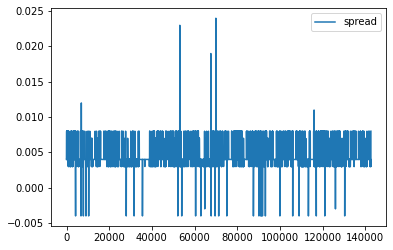

In [8]:
df1[['spread']].plot()

In [115]:
def prep_data_sym(T,n_imb,dt,n_spread):
    
    ticksize=0.004
    # adds the spread and mid prices
    T['spread']=np.round((T['ask']-T['bid'])/ticksize)*ticksize
    T['mid']=(T['bid']+T['ask'])/2
    
    #filter out spreads >= n_spread
    T = T.loc[(T.spread <= n_spread*ticksize) & (T.spread>0)]
    T['imb']=T['bs'] /(T['bs'] + T['as'])

#     T['imb']=(T['bs']*np.exp(0) +  T['bs2'] * np.exp(-1) + T['bs3']* np.exp(-2))/((T['bs']*np.exp(0) +  T['bs2']* np.exp(-1) + T['bs3']* np.exp(-2) + T['as']*np.exp(0) + T['as2']* np.exp(-1) + T['as3']* np.exp(-2)))
    #discretize imbalance into percentiles
    T['imb_bucket'] = pd.qcut(T['imb'], n_imb, labels=False, duplicates='drop')
    T['next_mid']=T['mid'].shift(-dt)
    #step ahead state variables
    T['next_spread']=T['spread'].shift(-dt)
    T['next_time']=T['time'].shift(-dt)
    T['next_imb_bucket']=T['imb_bucket'].shift(-dt)
    # step ahead change in price
    T['dM']=np.round((T['next_mid']-T['mid'])/ticksize*4)*ticksize/4
    T = T.loc[(T.dM <= ticksize*1.1) & (T.dM>=-ticksize*1.1)]
    # symetrize data
    T2 = T.copy(deep=True)
    T2['imb_bucket']=n_imb-1-T2['imb_bucket']
    T2['next_imb_bucket']=n_imb-1-T2['next_imb_bucket']
    T2['dM']=-T2['dM']
    T2['mid']=-T2['mid']
    T3=pd.concat([T,T2])
    T3.index = pd.RangeIndex(len(T3.index)) 
    return T3,ticksize

In [116]:
def estimate(T):
    no_move=T[T['dM']==0]
    no_move_counts=no_move.pivot_table(index=[ 'next_imb_bucket'], 
                     columns=['spread', 'imb_bucket'], 
                     values='time',
                     fill_value=0, 
                     aggfunc='count').unstack()
    Q_counts=np.resize(np.array(no_move_counts[0:(n_imb*n_imb)]),(n_imb,n_imb))
    # loop over all spreads and add block matrices
    for i in range(1,n_spread):
        Qi=np.resize(np.array(no_move_counts[(i*n_imb*n_imb):(i+1)*(n_imb*n_imb)]),(n_imb,n_imb))
        Q_counts=block_diag(Q_counts,Qi)
    #print Q_counts
    move_counts=T[(T['dM']!=0)].pivot_table(index=['dM'], 
                         columns=['spread', 'imb_bucket'], 
                         values='time',
                         fill_value=0, 
                         aggfunc='count').unstack()
    R_counts=np.resize(np.array(move_counts),(n_imb*n_spread,4))
    T1=np.concatenate((Q_counts,R_counts),axis=1).astype(float)
    for i in range(0,n_imb*n_spread):
        T1[i]=T1[i]/T1[i].sum()
    Q=T1[:,0:(n_imb*n_spread)]
    R1=T1[:,(n_imb*n_spread):]

    K=np.array([-0.004, -0.002, 0.002, 0.004])
    move_counts=T[(T['dM']!=0)].pivot_table(index=['spread','imb_bucket'], 
                     columns=['next_spread', 'next_imb_bucket'], 
                     values='time',
                     fill_value=0, 
                     aggfunc='count') #.unstack()

    R2_counts=np.resize(np.array(move_counts),(n_imb*n_spread,n_imb*n_spread))
    T2=np.concatenate((Q_counts,R2_counts),axis=1).astype(float)

    for i in range(0,n_imb*n_spread):
        T2[i]=T2[i]/T2[i].sum()
    R2=T2[:,(n_imb*n_spread):]
    Q2=T2[:,0:(n_imb*n_spread)]
    G1=np.dot(np.dot(np.linalg.inv(np.eye(n_imb*n_spread)-Q),R1),K)
    B=np.dot(np.linalg.inv(np.eye(n_imb*n_spread)-Q),R2)

    return G1,B,Q,Q2,R1,R2,K

In [117]:
def plot_Gstar(G1,B,T):
    G2=np.dot(B,G1)+G1
    G3=G2+np.dot(np.dot(B,B),G1)
    G4=G3+np.dot(np.dot(np.dot(B,B),B),G1)
    G5=G4+np.dot(np.dot(np.dot(np.dot(B,B),B),B),G1)
    G6=G5+np.dot(np.dot(np.dot(np.dot(np.dot(B,B),B),B),B),G1)
    plt.plot(imb,np.linspace(-0.005,0.005,n_imb)*0,label='Mid adj',marker='o')
    plt.plot(imb,np.linspace(-0.005,0.005,n_imb),label='Weighted mid adj',marker='o')
    for i in range(0,n_spread):
        plt.plot(imb,G6[(0+i*n_imb):(n_imb+i*n_imb)],label="spread = "+str(i+1)+" tick adj",marker='o')
#     plt.ylim(-0.01,0.01)
    plt.legend(loc='upper left')
    plt.title('Adjustments')
    plt.xlabel('Imbalance')
    return G6

In [118]:
n_imb=50
n_spread=1
dt=1
pd.set_option('mode.chained_assignment', None)
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
T,ticksize=prep_data_sym(df1,n_imb,dt,n_spread)

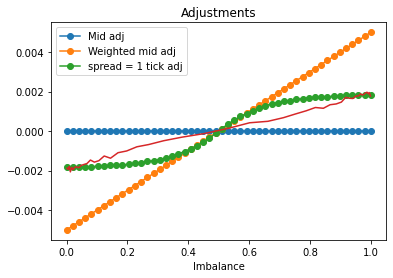

In [119]:
D = T.copy()

D["MidMove"] = np.abs(D["mid"]).shift(-10) - np.abs(D["mid"])
tst = D[["imb","MidMove"]]

tst['imb_bucket'] = pd.qcut(tst['imb'], n_imb, labels=False, duplicates='drop')
k = tst.groupby(['imb_bucket']).mean()

imb=np.linspace(0,1,n_imb)
G1,B,Q,Q2,R1,R2,K=estimate(T)
G6=plot_Gstar(G1,B,T)
plt.plot(k["imb"],k["MidMove"])

0.971353410269909

Text(0.5, 0, 'Imbalance')

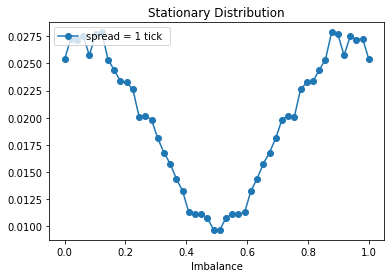

In [112]:
W=np.linalg.matrix_power(B,100)
for i in range(0,n_spread):
    plt.plot(imb,W[0][(0+i*n_imb):(n_imb+i*n_imb)],label="spread = "+str(i+1)+" tick ",marker='o')
    
plt.legend(loc='upper left')
plt.title('Stationary Distribution')
plt.xlabel('Imbalance')

MovieWriter imagemagick unavailable; using Pillow instead.


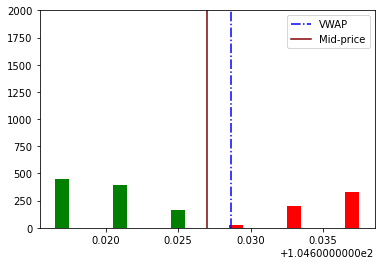

In [15]:

fig,axs = plt.subplots()
n = len(df1)


def animate(i):
    y=df1.iloc[i]
    axs.clear()
    ask_1 = 0
    ask_2 = 0
    ask_3 = 0
    
    bid_1 = 0
    bid_2 = 0
    bid_3 = 0
    
    bid_size_1 = 0
    bid_size_2 = 0
    bid_size_3 = 0
    
    ask_size_1 = 0
    ask_size_2 = 0
    ask_size_3 = 0
    
    
    if y["trade_side"] == 1 :
        ask_1 = y["price_same_1"]
        ask_2 = y["price_same_2"]
        ask_3 = y["price_same_3"]
        ask_size_1 = y["size_same_1"]
        ask_size_2 = y["size_same_2"]
        ask_size_3 = y["size_same_3"]

        bid_1 = y["price_contra_1"]
        bid_2 = y["price_contra_2"]
        bid_3 = y["price_contra_3"]
        bid_size_1 = y["size_contra_1"]
        bid_size_2 = y["size_contra_2"]
        bid_size_3 = y["size_contra_3"]

    else :
        bid_1 = y["price_same_1"]
        bid_2 = y["price_same_2"]
        bid_3 = y["price_same_3"]
        bid_size_1 = y["size_same_1"]
        bid_size_2 = y["size_same_2"]
        bid_size_3 = y["size_same_3"]

        ask_1 = y["price_contra_1"]
        ask_2 = y["price_contra_2"]
        ask_3 = y["price_contra_3"]
        ask_size_1 = y["size_contra_1"]
        ask_size_2 = y["size_contra_2"]
        ask_size_3 = y["size_contra_3"]
    
    mid = (bid_1 + ask_1)/2
    vwap = y.VWAP
    if vwap < bid_1 : vwap = bid_1
    elif vwap > ask_1 : vwap = ask_1
    
    plt.bar((bid_1,bid_2,bid_3,ask_1,ask_2,ask_3),\
            (bid_size_1,bid_size_2,bid_size_3,ask_size_1,ask_size_2,ask_size_3), width=0.001,\
            color=['green', 'green', 'green','red', 'red', 'red','blue'])
    plt.axvline(x = vwap, color = 'b', label = 'VWAP',ls='-.')
    plt.axvline(x = mid, color = 'maroon', label = 'Mid-price',ls='-')
    plt.ylim(0,2000)
    plt.legend()

anim=animation.FuncAnimation(fig,animate,repeat=False,blit=False,frames=100,
                             interval=10)
anim.save('.animation_ZTU2.gif', writer='imagemagick', fps=60)


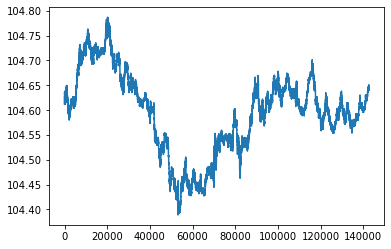

In [16]:
plt.plot(df1.wmid)

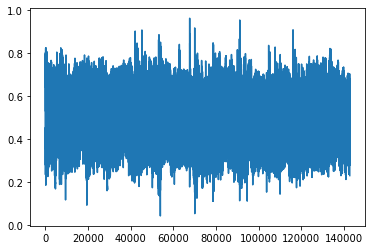

In [17]:
plt.plot(df1.imb)